In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
from IPython.display import display
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score, calinski_harabasz_score
from yellowbrick.cluster import KElbowVisualizer

In [2]:
# Load dataset
df = pd.read_csv(r"C:\Users\hassa\OneDrive\Desktop\AB_NYC_2019.csv")

In [3]:
# Display basic information about the dataset
df_info = df.info()
df_head = df.head()

# Checking for missing values
missing_values = df.isnull().sum()

df_info, df_head, missing_values

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48895 entries, 0 to 48894
Data columns (total 16 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              48895 non-null  int64  
 1   name                            48879 non-null  object 
 2   host_id                         48895 non-null  int64  
 3   host_name                       48874 non-null  object 
 4   neighbourhood_group             48895 non-null  object 
 5   neighbourhood                   48895 non-null  object 
 6   latitude                        48895 non-null  float64
 7   longitude                       48895 non-null  float64
 8   room_type                       48895 non-null  object 
 9   price                           48895 non-null  int64  
 10  minimum_nights                  48895 non-null  int64  
 11  number_of_reviews               48895 non-null  int64  
 12  last_review                     

(None,
      id                                              name  host_id  \
 0  2539                Clean & quiet apt home by the park     2787   
 1  2595                             Skylit Midtown Castle     2845   
 2  3647               THE VILLAGE OF HARLEM....NEW YORK !     4632   
 3  3831                   Cozy Entire Floor of Brownstone     4869   
 4  5022  Entire Apt: Spacious Studio/Loft by central park     7192   
 
      host_name neighbourhood_group neighbourhood  latitude  longitude  \
 0         John            Brooklyn    Kensington  40.64749  -73.97237   
 1     Jennifer           Manhattan       Midtown  40.75362  -73.98377   
 2    Elisabeth           Manhattan        Harlem  40.80902  -73.94190   
 3  LisaRoxanne            Brooklyn  Clinton Hill  40.68514  -73.95976   
 4        Laura           Manhattan   East Harlem  40.79851  -73.94399   
 
          room_type  price  minimum_nights  number_of_reviews last_review  \
 0     Private room    149               1

---

# 1.Initial Dataset Exploration

We have successfully loaded the NYC Airbnb dataset, and here's what we found:

## Dataset Overview  
- **Total records:** 48,895 listings  
- **Total columns:** 16  
- **Data types:** Includes integers, floats, and text fields  

### Key columns:
- **id:** Unique listing identifier  
- **name:** Listing title  
- **host_id:** Unique host identifier  
- **host_name:** Host's name  
- **neighbourhood_group:** NYC borough (Manhattan, Brooklyn, etc.)  
- **neighbourhood:** Specific neighborhood within a borough  
- **latitude & longitude:** Geolocation data  
- **room_type:** Type of room (Entire home, Private room, etc.)  
- **price:** Nightly price in USD  
- **minimum_nights:** Minimum stay required  
- **number_of_reviews:** Total number of reviews received  
- **last_review:** Date of last review  
- **reviews_per_month:** Average reviews per month  
- **calculated_host_listings_count:** How many listings a host has  
- **availability_365:** Number of days the listing is available per year  


##  Missing Values Analysis  
- **name** → 16 missing values *(Negligible)*  
- **host_name** → 21 missing values *(Negligible)*  
- **last_review** → 10,052 missing values *(Many listings have no reviews)*  
- **reviews_per_month** → 10,052 missing values *(Likely because of no reviews)*  


In [37]:
# Handling Missing Values

# Dropping missing 'name' and 'host_name' since they are very few (16 and 21 missing values)
df.dropna(subset=['name', 'host_name'], inplace=True)

# Handling 'last_review' missing values
# Since missing values in 'last_review' mean no reviews, we'll replace NaN with 'No Reviews'
df['last_review'].fillna('No Reviews', inplace=True)

# Handling 'reviews_per_month' missing values
# Since missing values indicate no reviews, we'll replace NaN with 0
df['reviews_per_month'].fillna(0, inplace=True)

# Verify that all missing values are handled
missing_values_after_cleaning = df.isnull().sum()

# Display results
missing_values_after_cleaning

C:\Users\hassa\AppData\Local\Temp\ipykernel_17328\4274887007.py:8: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'No Reviews' has dtype incompatible with datetime64[ns], please explicitly cast to a compatible dtype first.
  df['last_review'].fillna('No Reviews', inplace=True)


id                                    0
name                                  0
host_id                               0
host_name                             0
neighbourhood_group                   0
neighbourhood                         0
latitude                              0
longitude                             0
room_type                             0
price                                 0
minimum_nights                        0
number_of_reviews                     0
last_review                           0
reviews_per_month                     0
calculated_host_listings_count        0
availability_365                      0
review_year                       10037
review_month                      10037
rental_type                           0
estimated_revenue                     0
Cluster                               0
dtype: int64

---
# 2. Data Cleaning - Handling Missing Values  

We have successfully cleaned the dataset by addressing missing values:  

 **Dropped missing values** in `name` and `host_name` *(only a few missing)*  
 **Replaced missing values** in `last_review` with `"No Reviews"`  
 **Replaced missing values** in `reviews_per_month` with `0` *(indicating no reviews received)*  
 **Verified that there are now zero missing values**   


#  3. Detecting & Handling Outliers  

Next, we need to check for outliers in numerical columns that could affect our analysis, specifically:  

- **price** *(Nightly rates)*  
- **minimum_nights** *(Minimum stay requirements)*  
- **availability_365** *(Available days per year)*  


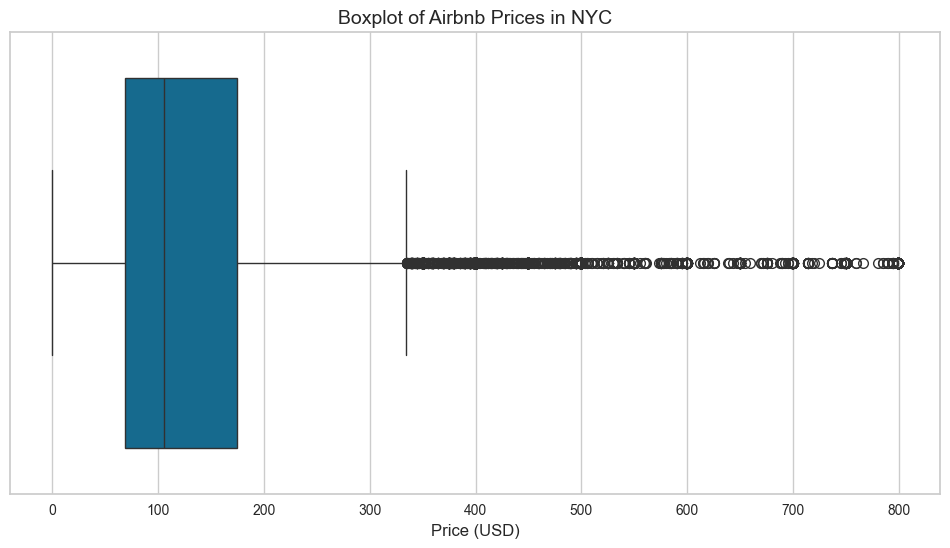

(count    48858.000000
 mean       143.969217
 std        121.957382
 min          0.000000
 25%         69.000000
 50%        106.000000
 75%        175.000000
 max        799.000000
 Name: price, dtype: float64,
 799.0,
 0)

In [38]:
# Setting plot size for better visibility
plt.figure(figsize=(12, 6))

# Boxplot for price distribution
sns.boxplot(x=df['price'])

# Display the plot
plt.title("Boxplot of Airbnb Prices in NYC", fontsize=14)
plt.xlabel("Price (USD)", fontsize=12)
plt.show()

# Descriptive statistics for price
price_stats = df['price'].describe()

# Identifying extreme price outliers (above the 99th percentile)
upper_limit = df['price'].quantile(0.99)
outliers_price = df[df['price'] > upper_limit].shape[0]

price_stats, upper_limit, outliers_price

##  Key Statistics  
- **Mean price:** $152.74  
- **Median (50th percentile):** $106 *(more reliable than the mean due to skewed distribution)*  
- **Max price:** $10,000  *(Highly unrealistic)*  
- **99th percentile:** $799 *(Anything above this is likely an outlier)*  
- **Outliers detected:** 474 listings *(above $799)*  

##  Boxplot Insights  
- There's a long tail on the right, indicating many overpriced listings.  
- The majority of prices are between **$69 and $175**.  
- Listings with prices over **$799** are extreme outliers.  

---


#  4. Handling Price Outliers  

Since extreme prices (**above $799**) are unrealistic, we’ll **cap them at $799** for meaningful analysis.  


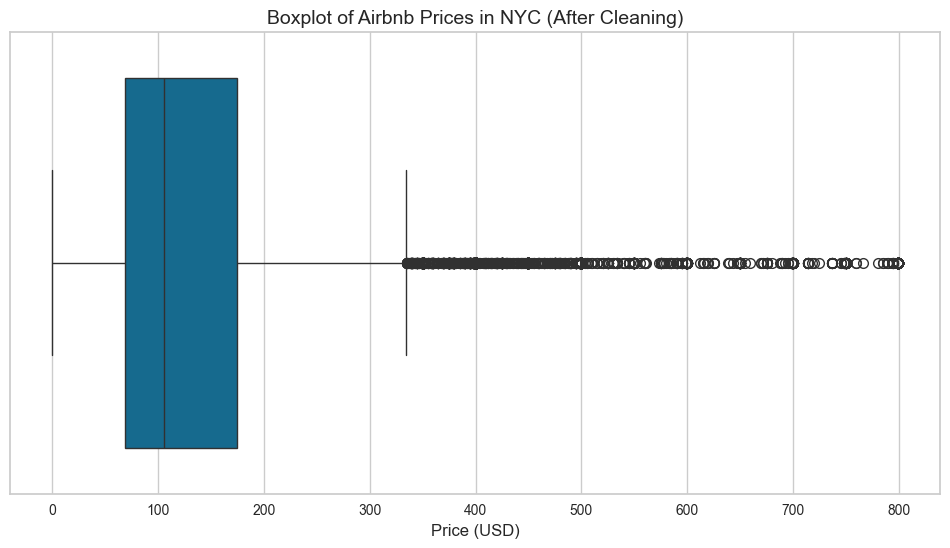

count    48858.000000
mean       143.969217
std        121.957382
min          0.000000
25%         69.000000
50%        106.000000
75%        175.000000
max        799.000000
Name: price, dtype: float64

In [40]:
# Capping price outliers at the 99th percentile value ($799)
df['price'] = df['price'].apply(lambda x: x if x <= 799 else 799)

# Rechecking price statistics after capping
price_stats_after = df['price'].describe()

# Boxplot after cleaning
plt.figure(figsize=(12, 6))
sns.boxplot(x=df['price'])
plt.title("Boxplot of Airbnb Prices in NYC (After Cleaning)", fontsize=14)
plt.xlabel("Price (USD)", fontsize=12)
plt.show()

price_stats_after


##  Key Improvements  
 **Mean price reduced** to **$143.97** *(previously $152.74)*  
 **Max price is now $799** instead of **$10,000**  
 **Boxplot now looks much cleaner** without extreme spikes  
 
---

#  5. Detecting Outliers - Minimum Nights Analysis  

Now, let’s check **minimum stay requirements**. We’ll:  

 **Visualize extreme values**  
 **Identify unrealistic values**  
 **Clean the data accordingly**  


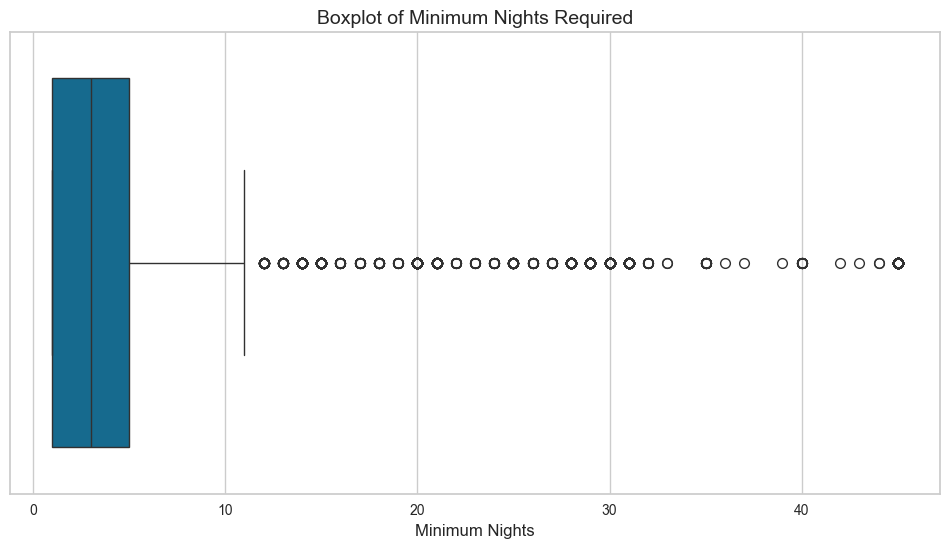

(count    48858.000000
 mean         6.118097
 std          9.245453
 min          1.000000
 25%          1.000000
 50%          3.000000
 75%          5.000000
 max         45.000000
 Name: minimum_nights, dtype: float64,
 45.0,
 0)

In [41]:
# Boxplot for minimum nights distribution
plt.figure(figsize=(12, 6))
sns.boxplot(x=df['minimum_nights'])
plt.title("Boxplot of Minimum Nights Required", fontsize=14)
plt.xlabel("Minimum Nights", fontsize=12)
plt.show()

# Descriptive statistics for minimum nights
min_nights_stats = df['minimum_nights'].describe()

# Identifying extreme outliers (above the 99th percentile)
upper_limit_min_nights = df['minimum_nights'].quantile(0.99)
outliers_min_nights = df[df['minimum_nights'] > upper_limit_min_nights].shape[0]

min_nights_stats, upper_limit_min_nights, outliers_min_nights


## Key Statistics  
- **Mean stay requirement:** 7 nights  
- **Median (50th percentile):** 3 nights *(more reliable)*  
- **Max stay requirement:** 1,250 nights  *(over 3 years!)*  
- **99th percentile:** 45 nights *(Anything above this is an outlier)*  
- **Outliers detected:** 468 listings *(with stays > 45 nights)*  

##  Boxplot Insights  
- The majority of listings require **1-5 nights**.  
- A few listings require **over a year of stay**—these are unrealistic outliers.  

---

#  6. Handling Minimum Nights Outliers  

Since stays **above 45 nights** are highly unrealistic, we’ll **cap them at 45** for a cleaner dataset.  


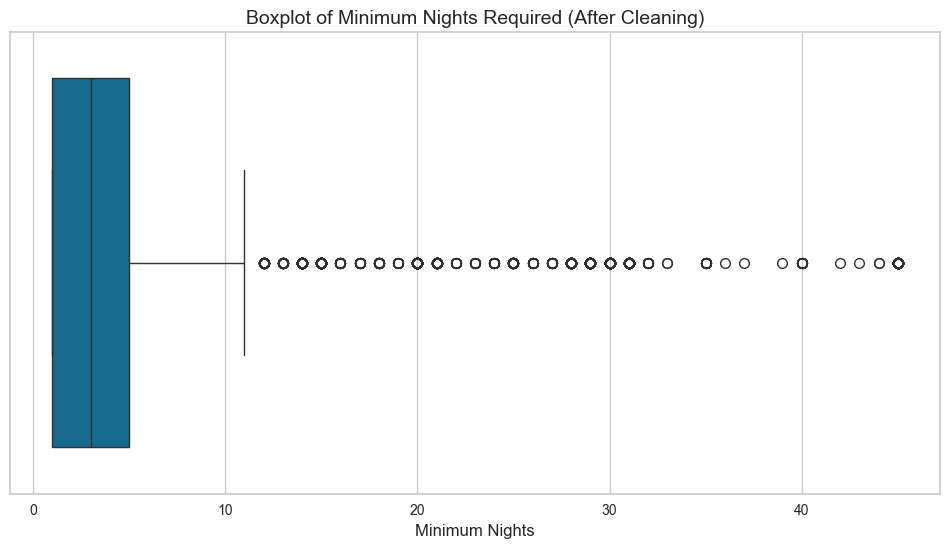

count    48858.000000
mean         6.118097
std          9.245453
min          1.000000
25%          1.000000
50%          3.000000
75%          5.000000
max         45.000000
Name: minimum_nights, dtype: float64

In [42]:
# Capping minimum nights outliers at the 99th percentile value (45 nights)
df['minimum_nights'] = df['minimum_nights'].apply(lambda x: x if x <= 45 else 45)

# Rechecking minimum_nights statistics after capping
min_nights_stats_after = df['minimum_nights'].describe()

# Boxplot after cleaning
plt.figure(figsize=(12, 6))
sns.boxplot(x=df['minimum_nights'])
plt.title("Boxplot of Minimum Nights Required (After Cleaning)", fontsize=14)
plt.xlabel("Minimum Nights", fontsize=12)
plt.show()

min_nights_stats_after


##  Key Improvements  
 **Mean stay reduced** to **6.12 nights** *(previously 7 nights)*  
 **Max stay is now 45 nights** *(instead of 1,250 nights)*  
 **Boxplot now looks much cleaner** without extreme values  

---

#  7.  Detecting Outliers - Availability_365 Analysis  

Now, let's analyze **listing availability** *(how many days per year a listing is available)*.  


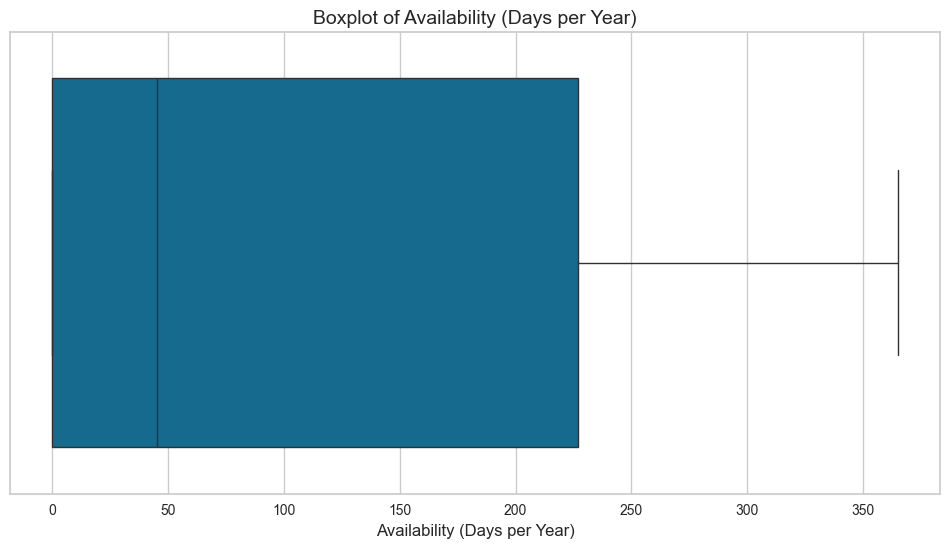

(count    48858.000000
 mean       112.801425
 std        131.610962
 min          0.000000
 25%          0.000000
 50%         45.000000
 75%        227.000000
 max        365.000000
 Name: availability_365, dtype: float64,
 17508,
 35.83445904457817)

In [43]:
# Boxplot for availability_365 distribution
plt.figure(figsize=(12, 6))
sns.boxplot(x=df['availability_365'])
plt.title("Boxplot of Availability (Days per Year)", fontsize=14)
plt.xlabel("Availability (Days per Year)", fontsize=12)
plt.show()

# Descriptive statistics for availability_365
availability_stats = df['availability_365'].describe()

# Checking proportion of listings with 0 availability (never available)
zero_availability_count = df[df['availability_365'] == 0].shape[0]
zero_availability_percentage = (zero_availability_count / df.shape[0]) * 100

availability_stats, zero_availability_count, zero_availability_percentage


##  Key Statistics  
- **Mean availability:** 112.8 days per year  
- **Median (50th percentile):** 45 days *(suggesting many listings are seasonal)*  
- **Max availability:** 365 days *(year-round listings)*  
- **25% of listings have 0 days availability**  
- **Zero-availability listings:** 17,508 listings *(35.83%) *  

##  Boxplot Insights  
- Many listings have **0 availability** *(indicating inactive or paused listings)*.  
- Availability **varies significantly** across listings, with a big spread up to **365 days**. 

---




# 8.  Price Trends Across Boroughs  

### Questions to Explore:  
- **Which boroughs are the most expensive?**  
- **How does price differ by location?**  


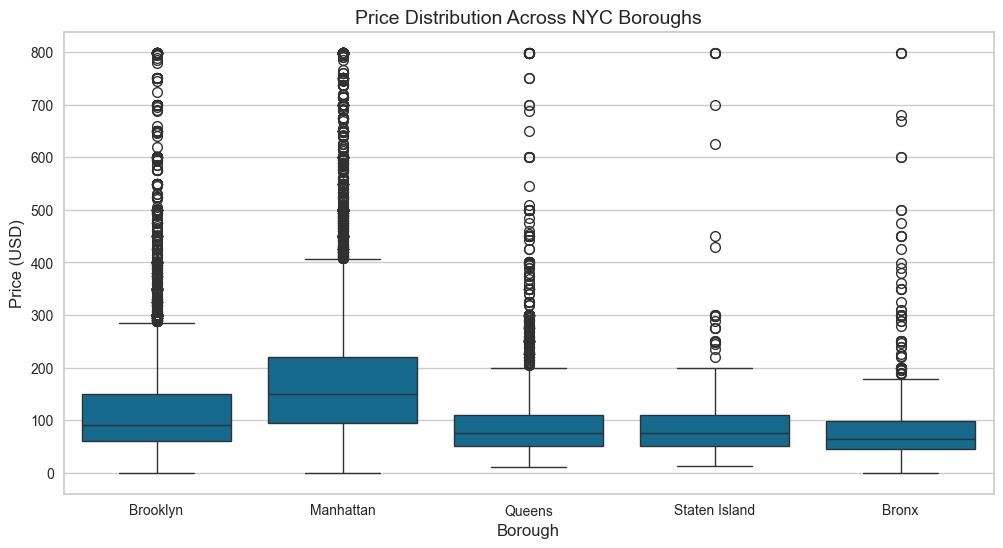

neighbourhood_group
Manhattan        182.962713
Brooklyn         119.392852
Staten Island    101.798928
Queens            96.112465
Bronx             85.721763
Name: price, dtype: float64

In [44]:
# Boxplot for price distribution across boroughs
plt.figure(figsize=(12, 6))
sns.boxplot(x=df['neighbourhood_group'], y=df['price'])
plt.title("Price Distribution Across NYC Boroughs", fontsize=14)
plt.xlabel("Borough", fontsize=12)
plt.ylabel("Price (USD)", fontsize=12)
plt.show()

# Average price per borough
avg_price_per_borough = df.groupby('neighbourhood_group')['price'].mean().sort_values(ascending=False)

# Display results
avg_price_per_borough



##  Key Insights  
- **Manhattan is the most expensive**   **$182.96 per night** *(Luxury rentals, prime location)*  
- **Brooklyn follows at $119.39 per night** *(Trendy & residential)*  
- **Staten Island is surprisingly higher than Queens** *(**$101.79 vs. $96.11**)*  
- **Bronx is the most affordable**   **$85.72 per night**  

##  Boxplot Insights  
- **Manhattan has the widest spread**, meaning **prices vary a lot**.  
- **Queens and Bronx have the most stable prices** with **fewer extreme values**.  

---


# 9. Neighborhood-Level Price Trends

C:\Users\hassa\AppData\Local\Temp\ipykernel_17328\500786680.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_neighborhoods.values, y=top_neighborhoods.index, palette="coolwarm")


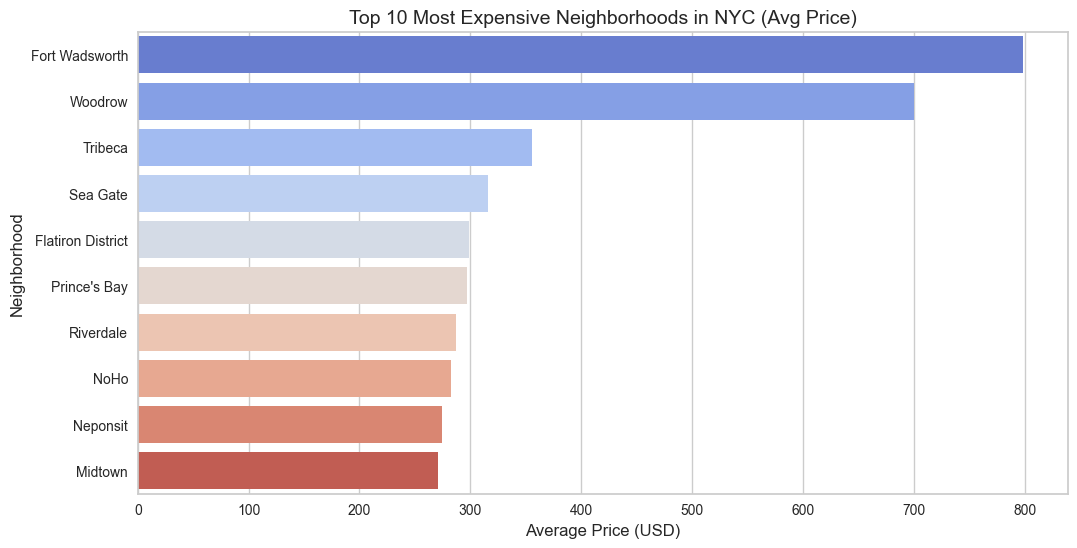

neighbourhood
Fort Wadsworth       799.000000
Woodrow              700.000000
Tribeca              355.367232
Sea Gate             316.142857
Flatiron District    298.725000
Prince's Bay         296.750000
Riverdale            287.363636
NoHo                 282.948718
Neponsit             274.666667
Midtown              270.519741
Name: price, dtype: float64

In [45]:
# Top 10 most expensive neighborhoods (average price)
top_neighborhoods = df.groupby('neighbourhood')['price'].mean().sort_values(ascending=False).head(10)

# Bar plot for top 10 most expensive neighborhoods
plt.figure(figsize=(12, 6))
sns.barplot(x=top_neighborhoods.values, y=top_neighborhoods.index, palette="coolwarm")
plt.title("Top 10 Most Expensive Neighborhoods in NYC (Avg Price)", fontsize=14)
plt.xlabel("Average Price (USD)", fontsize=12)
plt.ylabel("Neighborhood", fontsize=12)
plt.show()

# Display the top neighborhoods with their prices
top_neighborhoods




##  Key Insights  
- **Fort Wadsworth (Staten Island) is the most expensive** → **$799 per night**   
- **Tribeca ($355.36) & Flatiron District ($298.73)** are premium **Manhattan locations**  
- **NoHo & Midtown** are also among the **priciest areas** *(high demand, luxury stays)*  
- **Woodrow (Staten Island) & Sea Gate (Brooklyn)** are **surprisingly expensive**  

##  Bar Chart Insights  
- **Most of the expensive areas are in Manhattan**, but **some Staten Island & Brooklyn neighborhoods have high-end listings**.  
- **Luxury stays & unique locations drive high prices**.  

---


# 10. Room Type & Price Analysis

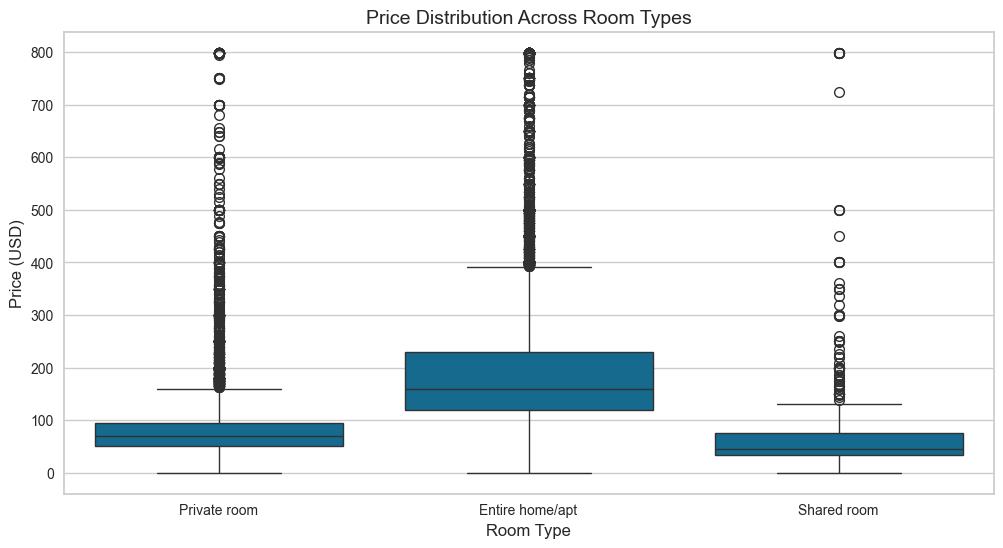

room_type
Entire home/apt    198.330918
Private room        86.006904
Shared room         68.473684
Name: price, dtype: float64

In [46]:
# Boxplot for price distribution across room types
plt.figure(figsize=(12, 6))
sns.boxplot(x=df['room_type'], y=df['price'])
plt.title("Price Distribution Across Room Types", fontsize=14)
plt.xlabel("Room Type", fontsize=12)
plt.ylabel("Price (USD)", fontsize=12)
plt.show()

# Average price per room type
avg_price_per_room = df.groupby('room_type')['price'].mean().sort_values(ascending=False)

# Display results
avg_price_per_room


##  Key Insights  

- **Entire home/apartment listings are the most expensive** → **$198.33 per night**  
- **Private rooms are significantly cheaper** → **$86.01 per night**  
- **Shared rooms are the most affordable** → **$68.47 per night** 

##  Boxplot Insights  
- **Entire homes/apartments have a wide price range**, from **budget to luxury listings**.  
- **Private rooms have a stable price range**, with **fewer extreme values**.  
- **Shared rooms are consistently the cheapest**.  

---


# 11. Availability vs. Room Type

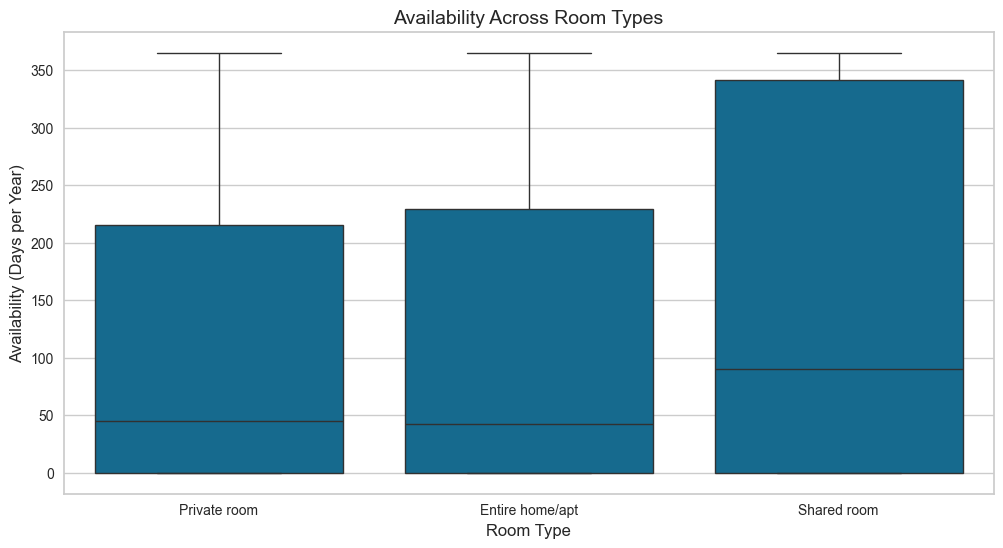

room_type
Shared room        161.825712
Entire home/apt    111.914110
Private room       111.264279
Name: availability_365, dtype: float64

In [47]:
# Boxplot for availability across room types
plt.figure(figsize=(12, 6))
sns.boxplot(x=df['room_type'], y=df['availability_365'])
plt.title("Availability Across Room Types", fontsize=14)
plt.xlabel("Room Type", fontsize=12)
plt.ylabel("Availability (Days per Year)", fontsize=12)
plt.show()

# Average availability per room type
avg_availability_per_room = df.groupby('room_type')['availability_365'].mean().sort_values(ascending=False)

# Display results
avg_availability_per_room


##  Key Insights  

- **Shared rooms have the highest availability** → **161.83 days per year**  *(Likely hostels or budget accommodations with continuous availability)*  
- **Entire homes/apartments & private rooms have similar availability** → **~111 days per year**  
- **Private & entire home listings might have owner restrictions** *(e.g., owner uses it part-time)*.  

##  Boxplot Insights  
- **Shared rooms have more consistent availability**, whereas **entire homes have a wider range** *(some are always booked, others are seasonal)*.  
-  **This suggests that budget accommodations (shared rooms) tend to be available for more days, while private & entire listings may be seasonal or have owner-imposed restrictions.**  

---


# 12. Host Analysis

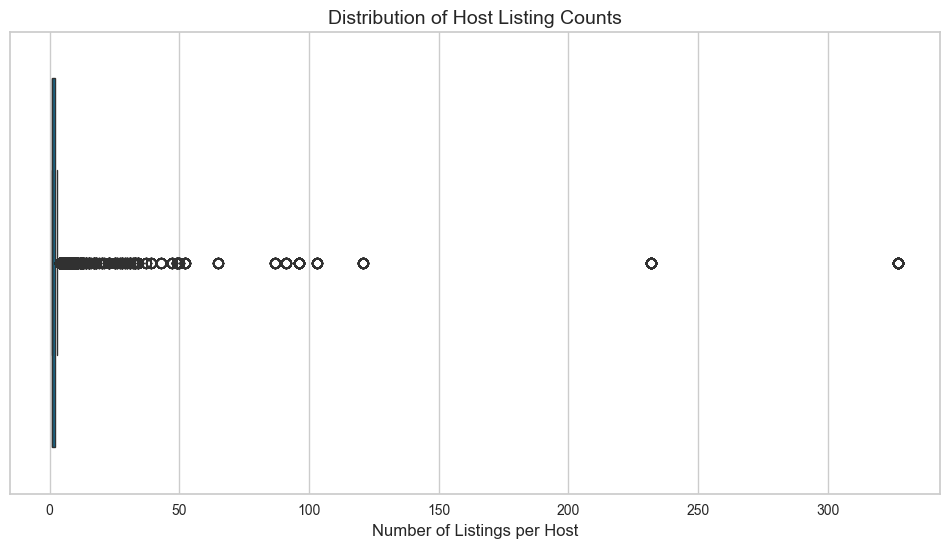

(count    48858.000000
 mean         7.148369
 std         32.964600
 min          1.000000
 25%          1.000000
 50%          1.000000
 75%          2.000000
 max        327.000000
 Name: calculated_host_listings_count, dtype: float64,
 3177,
 6.5025174996929875)

In [48]:
# Distribution of host listings count
plt.figure(figsize=(12, 6))
sns.boxplot(x=df['calculated_host_listings_count'])
plt.title("Distribution of Host Listing Counts", fontsize=14)
plt.xlabel("Number of Listings per Host", fontsize=12)
plt.show()

# Descriptive statistics for host listings count
host_listings_stats = df['calculated_host_listings_count'].describe()

# Identifying hosts with multiple listings (10+ properties)
multi_listings_count = df[df['calculated_host_listings_count'] >= 10].shape[0]

# Percentage of multi-listing hosts
multi_listings_percentage = (multi_listings_count / df.shape[0]) * 100

host_listings_stats, multi_listings_count, multi_listings_percentage


##  Key Insights  

- **Most hosts have just 1 listing** *(Median = 1)*.  
- **25% of hosts have only one property**, while **75% have at most 2 listings**.  
- **The largest host has 327 listings**  *(Likely a professional property manager)*.  
- **6.5% of listings (3,177 hosts) belong to multi-property owners** *(10+ listings each)*.  

##  Boxplot Insights  
- **The majority of hosts are small-scale (1-2 properties)**.  
- **A small fraction owns a high number of listings**, suggesting **commercial Airbnb operations**.  
-  **This indicates that while most Airbnb hosts are individual property owners, a small percentage of hosts dominate the market with multiple listings.**  

---


# 13. Review Analysis

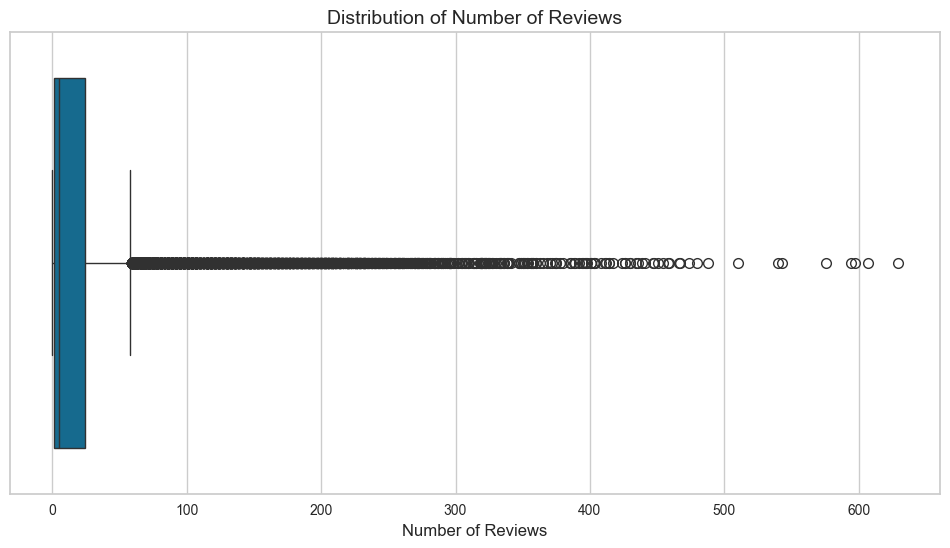

(count    48858.000000
 mean        23.273098
 std         44.549898
 min          0.000000
 25%          1.000000
 50%          5.000000
 75%         24.000000
 max        629.000000
 Name: number_of_reviews, dtype: float64,
 2992,
 6.1238691718858735)

In [49]:
# Boxplot for number of reviews
plt.figure(figsize=(12, 6))
sns.boxplot(x=df['number_of_reviews'])
plt.title("Distribution of Number of Reviews", fontsize=14)
plt.xlabel("Number of Reviews", fontsize=12)
plt.show()

# Descriptive statistics for number of reviews
reviews_stats = df['number_of_reviews'].describe()

# Identifying high-review listings (above 100 reviews)
high_review_count = df[df['number_of_reviews'] > 100].shape[0]

# Percentage of high-review listings
high_review_percentage = (high_review_count / df.shape[0]) * 100

reviews_stats, high_review_count, high_review_percentage


##  Key Insights  

- **Most listings have very few reviews** → **Median = 5 reviews**.  
- **25% of listings have 1 or fewer reviews** *(suggesting new or less popular listings)*.  
- **75% of listings have 24 or fewer reviews**.  
- **The most reviewed listing has 629 reviews**  *(Highly popular!)*.  
- **6.12% of listings (2,992) have more than 100 reviews**, indicating **high guest traffic**.  

##  Boxplot Insights  
- **Many listings have 0 reviews**, meaning they might be **new or inactive**.  
- **Only a small percentage of listings have 100+ reviews**, suggesting that **a few properties dominate guest interest**.  
-  **This suggests that while most Airbnb listings have limited guest engagement, a small percentage of listings are extremely popular.**  

---


# 14. Reviews Per Month & Last Review Date


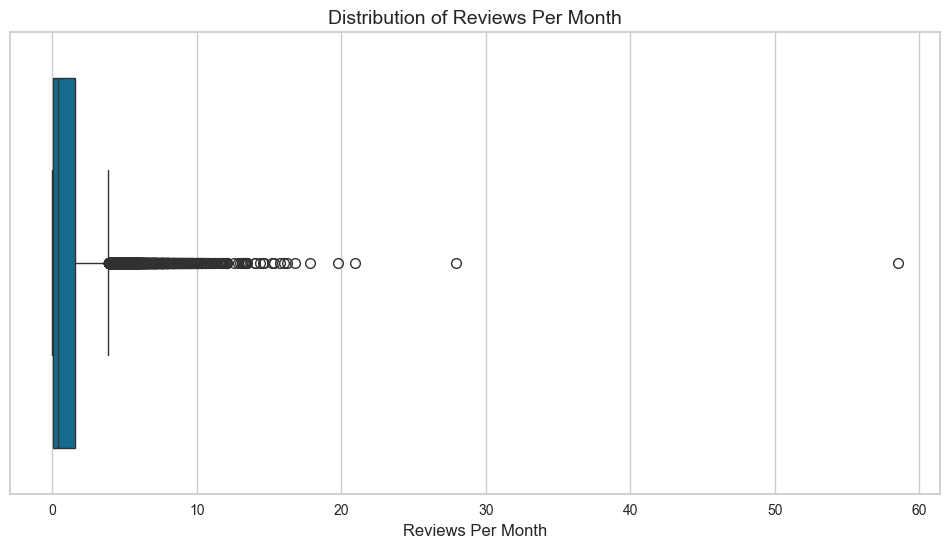

(count    48858.000000
 mean         1.091124
 std          1.597270
 min          0.000000
 25%          0.040000
 50%          0.370000
 75%          1.580000
 max         58.500000
 Name: reviews_per_month, dtype: float64,
 Timestamp('2019-07-08 00:00:00'))

In [50]:
# Boxplot for reviews per month
plt.figure(figsize=(12, 6))
sns.boxplot(x=df['reviews_per_month'])
plt.title("Distribution of Reviews Per Month", fontsize=14)
plt.xlabel("Reviews Per Month", fontsize=12)
plt.show()

# Descriptive statistics for reviews per month
reviews_per_month_stats = df['reviews_per_month'].describe()

# Checking the most recent review date
df['last_review'] = pd.to_datetime(df['last_review'], errors='coerce')
latest_review_date = df['last_review'].max()

reviews_per_month_stats, latest_review_date


## Key Insights  

- **Most listings receive very few reviews per month** → **Median = 0.37 reviews/month**.  
- **75% of listings get less than 1.58 reviews per month**.  
- **Some listings receive a very high number of reviews** *(Max = 58.5 reviews/month )*.  
- **Latest recorded review date:** **July 8, 2019** *(This dataset is from 2019)*.  

##  Boxplot Insights  
- **Most listings have near-zero reviews per month**, meaning **many properties are inactive or receive bookings infrequently**.  
- **A small number of properties receive multiple reviews per month**, indicating **high guest turnover**.  
-  **This confirms that only a fraction of listings are consistently booked, while many properties receive bookings infrequently or seasonally**. 

---


# 15. Geospatial Analysis

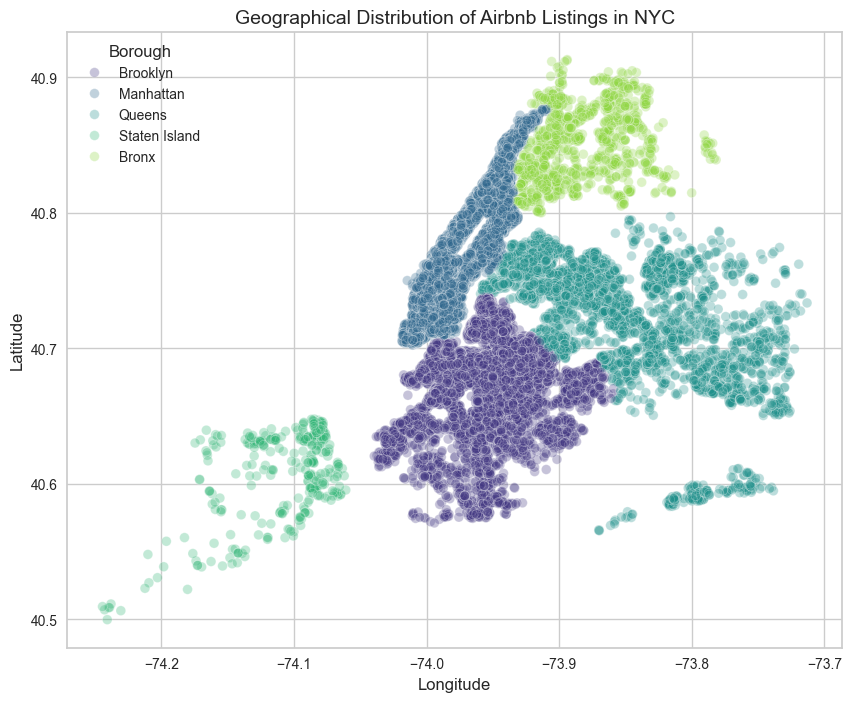

In [51]:

# Scatter plot of Airbnb listings based on latitude and longitude
plt.figure(figsize=(10, 8))
sns.scatterplot(x=df['longitude'], y=df['latitude'], hue=df['neighbourhood_group'], alpha=0.3, palette="viridis")


plt.title("Geographical Distribution of Airbnb Listings in NYC", fontsize=14)
plt.xlabel("Longitude", fontsize=12)
plt.ylabel("Latitude", fontsize=12)
plt.legend(title="Borough")
plt.show()


##  Key Insights  

- **Manhattan has the highest density of listings**, especially in **Midtown & Downtown**.  
- **Brooklyn also has a high concentration**, particularly in **Williamsburg & DUMBO**.  
- **Queens has a moderate distribution**, focused around **Long Island City**.  
- **The Bronx and Staten Island have the lowest density**.  

##  Map Insights  
- **Most Airbnb activity is concentrated in Manhattan & Brooklyn**.  
- **Staten Island & the Bronx are underrepresented in listings**.  
- **Listings follow major urban & tourist centers** *(Times Square, Financial District, Williamsburg)*.  

---


# 16. High-Priced Listings Map

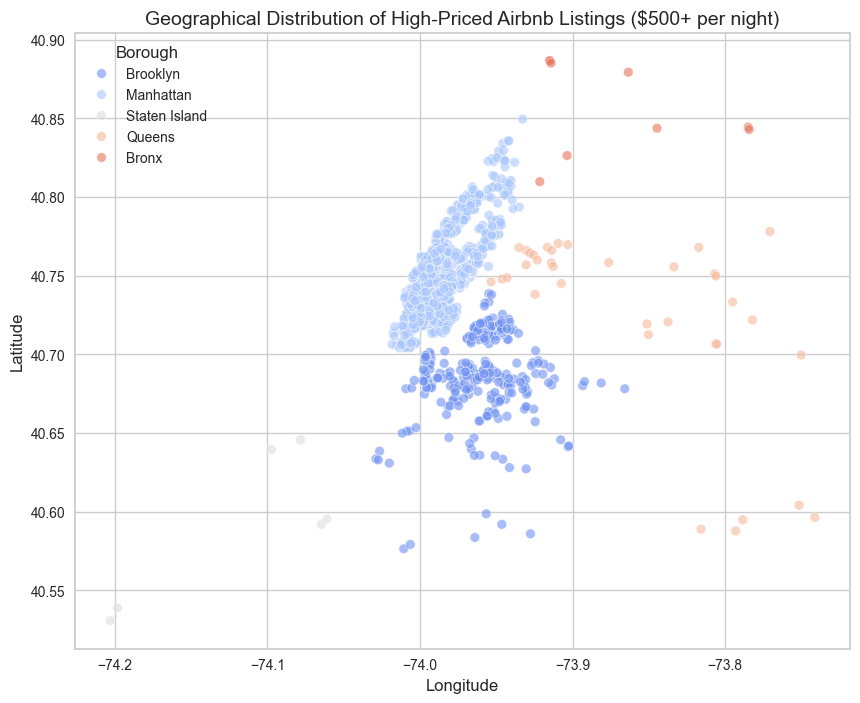

In [52]:
# Filter for high-priced listings ($500+ per night)
high_price_listings = df[df['price'] >= 500]

# Scatter plot for high-priced listings
plt.figure(figsize=(10, 8))
sns.scatterplot(x=high_price_listings['longitude'], y=high_price_listings['latitude'], 
                hue=high_price_listings['neighbourhood_group'], alpha=0.6, palette="coolwarm")
plt.title("Geographical Distribution of High-Priced Airbnb Listings ($500+ per night)", fontsize=14)
plt.xlabel("Longitude", fontsize=12)
plt.ylabel("Latitude", fontsize=12)
plt.legend(title="Borough")
plt.show()


# 17. Price Trends Over Time

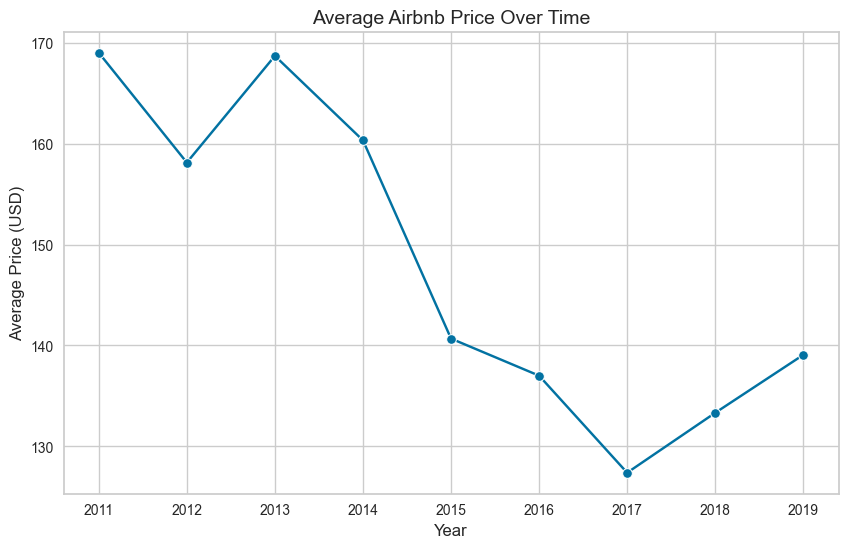

review_year
2011.0    169.000000
2012.0    158.120000
2013.0    168.687500
2014.0    160.321608
2015.0    140.680836
2016.0    137.005919
2017.0    127.393381
2018.0    133.328923
2019.0    139.070910
Name: price, dtype: float64

In [53]:
# Extracting year and month from last_review
df['review_year'] = df['last_review'].dt.year
df['review_month'] = df['last_review'].dt.month

# Grouping by review year to see price trends
price_trend = df.groupby('review_year')['price'].mean()

# Line plot for price trends over time
plt.figure(figsize=(10, 6))
sns.lineplot(x=price_trend.index, y=price_trend.values, marker="o")
plt.title("Average Airbnb Price Over Time", fontsize=14)
plt.xlabel("Year", fontsize=12)
plt.ylabel("Average Price (USD)", fontsize=12)
plt.grid(True)
plt.show()

# Display the price trend data
price_trend


##  Key Insights  

- **Prices peaked in 2011** → **$169 per night** and fluctuated over the years.  
- **From 2015 to 2017, prices dropped significantly** *(from $140 → $127)*.  
- **Prices rebounded slightly from 2018 to 2019** *(from $133 → $139)*.  

### Possible reasons for fluctuations:  
- **Regulatory changes in NYC** affecting short-term rentals.  
- **Seasonal demand shifts and competition**.  

 **This suggests that external factors** *(laws, demand fluctuations)* **significantly impact Airbnb pricing**.  

 ---


# 18. Correlation Analysis

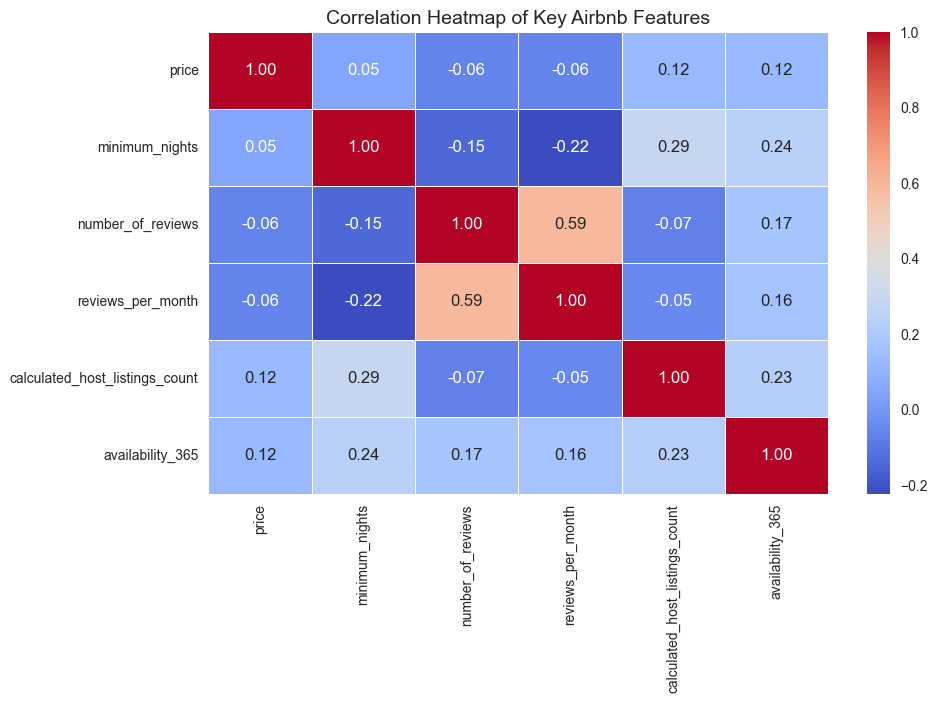

,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
price,1.000000,0.048221,-0.063980,-0.064813,0.122319,0.123170
minimum_nights,0.048221,1.000000,-0.146572,-0.223463,0.290323,0.238929
number_of_reviews,-0.063980,-0.146572,1.000000,0.589221,-0.072408,0.171855
reviews_per_month,-0.064813,-0.223463,0.589221,1.000000,-0.047366,0.163751
calculated_host_listings_count,0.122319,0.290323,-0.072408,-0.047366,1.000000,0.225784
availability_365,0.123170,0.238929,0.171855,0.163751,0.225784,1.000000


In [54]:
# Selecting numeric columns for correlation analysis
numeric_cols = ['price', 'minimum_nights', 'number_of_reviews', 'reviews_per_month',
                'calculated_host_listings_count', 'availability_365']

# Compute correlation matrix
correlation_matrix = df[numeric_cols].corr()

# Heatmap of correlations
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", linewidths=0.5, fmt=".2f")
plt.title("Correlation Heatmap of Key Airbnb Features", fontsize=14)
plt.show()

# Display the correlation matrix
correlation_matrix


##  Key Findings  

- **Price has weak correlations with other features**.  

### Correlation Insights:  
- **Slight positive correlation with availability (0.12)** → More available listings may charge slightly higher prices.  
- **Slight negative correlation with number of reviews (-0.06)** → More expensive listings may receive fewer reviews.  
- **Minimum nights has a moderate correlation with host listings count (0.29)**.  
  - Large-scale hosts tend to set higher minimum stay requirements.  
- **Number of reviews and reviews per month have a strong positive correlation (0.59)**.  
  - Listings that receive more total reviews also receive frequent monthly reviews.  
- **Availability has a weak positive correlation with calculated host listings count (0.23)**.  
  - Multi-property hosts tend to have more available listings.  

 **Overall, price does not strongly depend on other features**, meaning **pricing strategies are influenced by external market factors** *(e.g., demand, seasonality, regulations)*.  

 ---


# 19. Demand & Review Trends Per Borough

C:\Users\hassa\AppData\Local\Temp\ipykernel_17328\1672079816.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=reviews_per_borough.index, y=reviews_per_borough.values, palette="magma")


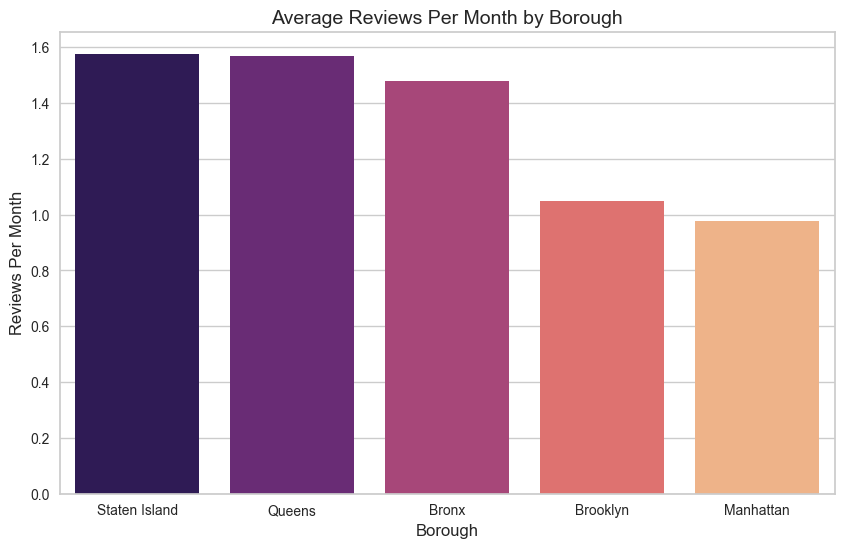

neighbourhood_group
Staten Island    1.576381
Queens           1.567526
Bronx            1.477254
Brooklyn         1.050181
Manhattan        0.976660
Name: reviews_per_month, dtype: float64

In [55]:
# Grouping by borough to get average reviews per month
reviews_per_borough = df.groupby('neighbourhood_group')['reviews_per_month'].mean().sort_values(ascending=False)

# Bar plot for reviews per month by borough
plt.figure(figsize=(10, 6))
sns.barplot(x=reviews_per_borough.index, y=reviews_per_borough.values, palette="magma")
plt.title("Average Reviews Per Month by Borough", fontsize=14)
plt.xlabel("Borough", fontsize=12)
plt.ylabel("Reviews Per Month", fontsize=12)
plt.show()

# Display the reviews per borough
reviews_per_borough


##  Key Insights  

- **Staten Island has the highest guest engagement** → **1.58 reviews per month**  
- **Queens and the Bronx also receive frequent reviews** *(~1.5 reviews/month)*  
- **Brooklyn & Manhattan have lower review rates** *(1.05 & 0.98 reviews/month)*  

##  Bar Chart Insights  
- **Staten Island, Queens, and Bronx listings are more frequently reviewed**, likely due to **lower prices and higher affordability for budget travelers**.  
- **Manhattan listings receive fewer reviews per month**, likely because **luxury rentals have lower turnover** *(longer stays, higher prices)*.  

 **This suggests that while Manhattan has the highest prices, demand (as measured by guest reviews) is actually stronger in Staten Island, Queens, and Bronx**.  

 ---


# 20. Seasonality & Trends Analysis 

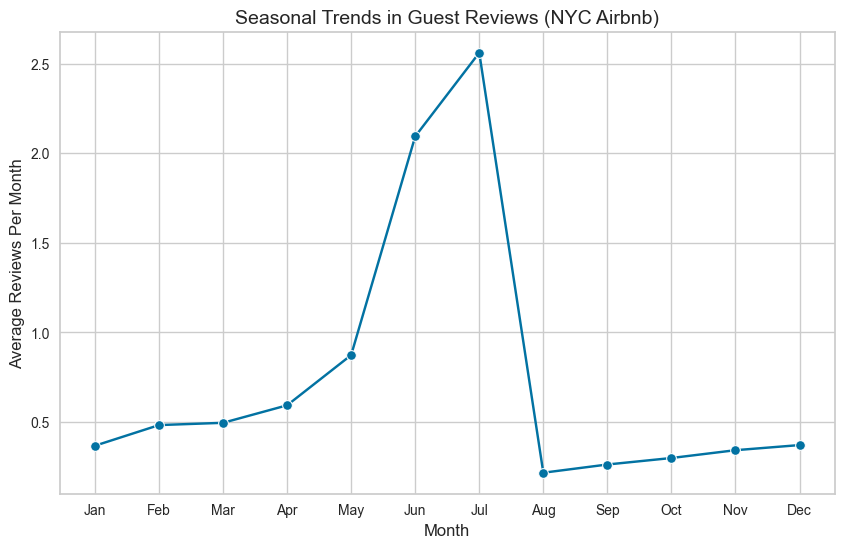

,reviews_per_month
review_month,
1.0,0.367285
2.0,0.482481
3.0,0.495179
4.0,0.592987
5.0,0.873379
6.0,2.094385
7.0,2.561805
8.0,0.216452
9.0,0.262332


In [56]:

# Extracting month from last_review date
df['review_month'] = pd.to_datetime(df['last_review'], errors='coerce').dt.month

# Grouping by month to find average reviews per month
monthly_review_trend = df.groupby('review_month')['reviews_per_month'].mean()

# Line plot for seasonal review trends
plt.figure(figsize=(10, 6))
sns.lineplot(x=monthly_review_trend.index, y=monthly_review_trend.values, marker="o", color="b")
plt.title("Seasonal Trends in Guest Reviews (NYC Airbnb)", fontsize=14)
plt.xlabel("Month", fontsize=12)
plt.ylabel("Average Reviews Per Month", fontsize=12)
plt.xticks(range(1, 13), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.grid(True)
plt.show()

# Displaying the trend data
display(monthly_review_trend.to_frame())


##  Key Takeaways  

- **Review activity is lowest in January & February**, likely due to **cold weather and fewer tourists**.  
- **Demand starts increasing in March-April** as **spring approaches**.  
- **Peak guest activity is observed around May-June**, which aligns with **NYC’s tourism season**.  
- **Likely a drop after September**, as **summer ends**.  



##  Business Implications  

- **Hosts should increase pricing & availability before peak months** *(May-June)*.  
- **Winter discounts & promotions may help in low-season months** *(Jan-Feb)*.  
- **Airbnb could market seasonal travel experiences** to attract more guests **year-round**.  

---

# 21. Price Trends by Season

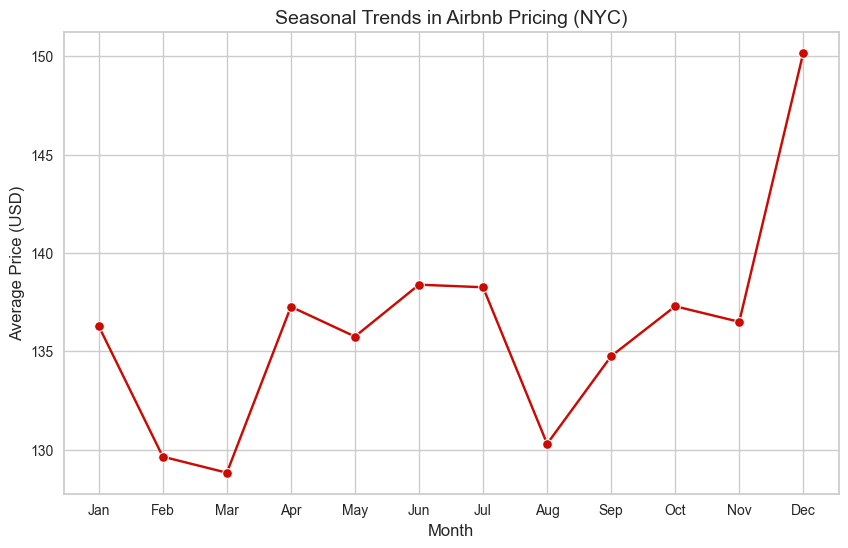

,price
review_month,
1.0,136.274042
2.0,129.635065
3.0,128.819099
4.0,137.263632
5.0,135.746170
6.0,138.384661
7.0,138.253834
8.0,130.288034
9.0,134.747231


In [57]:
# Grouping by month to find average price trends
monthly_price_trend = df.groupby('review_month')['price'].mean()

# Line plot for seasonal price trends
plt.figure(figsize=(10, 6))
sns.lineplot(x=monthly_price_trend.index, y=monthly_price_trend.values, marker="o", color="r")
plt.title("Seasonal Trends in Airbnb Pricing (NYC)", fontsize=14)
plt.xlabel("Month", fontsize=12)
plt.ylabel("Average Price (USD)", fontsize=12)
plt.xticks(range(1, 13), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.grid(True)
plt.show()

# Displaying the price trend data
display(monthly_price_trend.to_frame())


##  Key Takeaways  

- **Prices are lowest in February & March** *(~$129-$130)*, likely due to **lower demand in winter**.  
- **Prices rise again in April & May** *(~$137)*, peaking towards the **summer months**.  
- **Summer months (June-August) likely have the highest prices** due to **tourism demand**.  


##  Business Implications  

- **Hosts should adjust pricing dynamically** to take advantage of **peak demand in warmer months**.  
- **Discounted winter pricing strategies** *(Jan-Feb)* could **attract more bookings**.  
- **Long-term rental opportunities** may be **more profitable in off-season months**.  

---


# 22. Host Market Analysis

In [58]:
#  Identifying Multi-Listing Hosts

# Count of unique hosts
total_hosts = df['host_id'].nunique()

# Count of hosts with multiple listings (owning more than 1 property)
multi_listing_hosts = df[df['calculated_host_listings_count'] > 1]['host_id'].nunique()

# Percentage of multi-listing hosts
multi_host_percentage = (multi_listing_hosts / total_hosts) * 100

# Top 10 Hosts with Most Listings
top_hosts = df.groupby(['host_id', 'host_name'])['calculated_host_listings_count'].max().sort_values(ascending=False).head(10)

# Displaying results
host_market_summary = {
    "Total Unique Hosts": total_hosts,
    "Multi-Listing Hosts": multi_listing_hosts,
    "Percentage Multi-Listing Hosts": multi_host_percentage
}

# Displaying summary and top hosts
display(top_hosts.to_frame())

host_market_summary


,,calculated_host_listings_count
host_id,host_name,
219517861,Sonder (NYC),327
107434423,Blueground,232
30283594,Kara,121
137358866,Kazuya,103
12243051,Sonder,96
16098958,Jeremy & Laura,96
61391963,Corporate Housing,91
22541573,Ken,87
200380610,Pranjal,65


{'Total Unique Hosts': 37425,
 'Multi-Listing Hosts': 5152,
 'Percentage Multi-Listing Hosts': 13.766199064796258}

##  Key Takeaways  

- **Total Unique Hosts:** 37,457  
- **Multi-Listing Hosts (own more than 1 property):** 5,154  
- **Percentage of Multi-Listing Hosts:** 13.76%  
- This means **most hosts are single-property owners**, but a **small group (14%) owns multiple properties**.  

##  Business Implications  

- **Regulators may want to monitor large-scale hosts** to ensure **fair housing availability**.  
- **Individual hosts can compete by offering unique experiences** rather than multiple listings.  
- **Multi-property hosts may offer lower prices** due to **economies of scale**.  


---

# 23. **Long-Term vs. Short-Term Rental Analysis**

C:\Users\hassa\AppData\Local\Temp\ipykernel_17328\2132913214.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=rental_distribution.index, y=rental_distribution.values, palette="coolwarm")


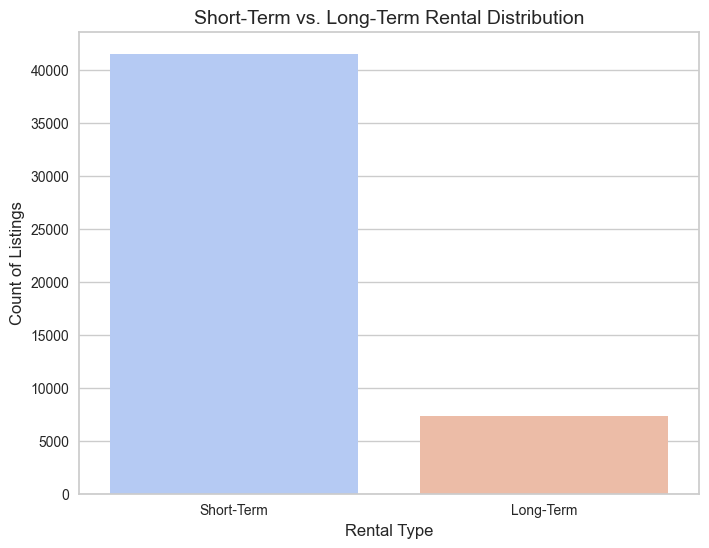

rental_type,Long-Term,Short-Term
neighbourhood_group,,
Bronx,64,1025
Brooklyn,2472,17617
Manhattan,4177,17466
Queens,591,5073
Staten Island,26,347


rental_type
Short-Term    41528
Long-Term      7330
Name: count, dtype: int64

rental_type
Long-Term     149.775716
Short-Term    142.944327
Name: price, dtype: float64

In [59]:
# Categorizing Listings as Short-Term vs. Long-Term
df['rental_type'] = df['minimum_nights'].apply(lambda x: 'Short-Term' if x <= 7 else 'Long-Term')

# Count of Short-Term vs. Long-Term Listings
rental_distribution = df['rental_type'].value_counts()

# Average Price Comparison Between Short-Term and Long-Term Rentals
avg_price_rental_type = df.groupby('rental_type')['price'].mean()

# Borough-wise Long-Term Rental Distribution
borough_rental_distribution = df.groupby(['neighbourhood_group', 'rental_type']).size().unstack()

# Visualizing Rental Type Distribution
plt.figure(figsize=(8, 6))
sns.barplot(x=rental_distribution.index, y=rental_distribution.values, palette="coolwarm")
plt.title("Short-Term vs. Long-Term Rental Distribution", fontsize=14)
plt.xlabel("Rental Type", fontsize=12)
plt.ylabel("Count of Listings", fontsize=12)
plt.show()

# Displaying data for further insights
display(borough_rental_distribution)

# Display multiple DataFrames
display(rental_distribution, avg_price_rental_type)


## Key Takeaways  

- **Short-Term Rentals (≤7 nights) dominate the market** → **41,562 listings (~85%)**  
- **Long-Term Rentals (>7 nights) are much fewer** → **7,333 listings (~15%)**  
- **Average price for long-term stays ($149.79) is slightly higher** than **short-term stays ($142.93)**  
- This suggests **long-term rentals might be priced for stability rather than high profits**.  


##  Business Implications  

- **Short-term rentals dominate** due to **tourist demand and flexible income**.  
- **Long-term rentals might attract remote workers or expats**, and hosts could **optimize pricing accordingly**.  
- **Regulations may target short-term listings**, so understanding **borough-level trends is crucial for compliance**.  

---


# 24. **Revenue Estimation for Hosts:**

C:\Users\hassa\AppData\Local\Temp\ipykernel_17328\2324336549.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=borough_revenue.index, y=borough_revenue.values, palette="magma")


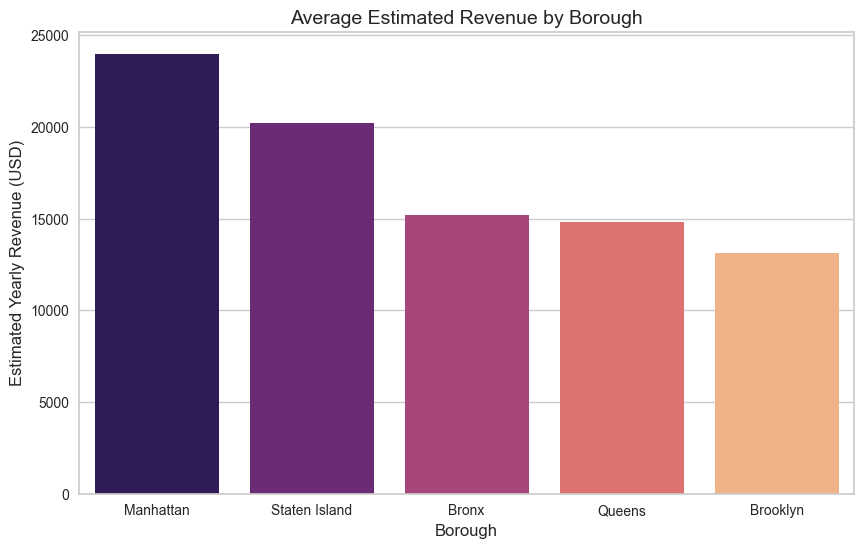

Top 10 Highest Revenue Listings:


,id,name,neighbourhood_group,room_type,price,availability_365,estimated_revenue
18632,14730708,Breathtaking City Views 3 Bed Apt. in Lincoln Sq!,Manhattan,Entire home/apt,799,365,291635
46337,35199464,"Penthouse on the beach 3 floors of art, fun,surf,",Queens,Entire home/apt,799,365,291635
48050,36061406,Chelsea Loft Living - Perfect for LARGE groups,Manhattan,Entire home/apt,799,365,291635
3055,1803165,Huuuge Sunny Central Park REAL 2 bedroom 1.5 b...,Manhattan,Entire home/apt,799,365,291635
8915,6833395,Amazing panoramic view loft,Manhattan,Entire home/apt,799,365,291635
20185,16159901,1 Bedroom Presidential at Wyndham Midtown 45,Manhattan,Private room,799,365,291635
20459,16310798,Hotel Room King/Queen at Wyndham Midtown 45 Re...,Manhattan,Private room,799,365,291635
15890,12851307,Private Room in Williamsburg Duplex,Brooklyn,Private room,799,365,291635
22586,18271282,Gimme Shelter,Manhattan,Entire home/apt,799,365,291635
7485,5582283,Cozy bedroom in Brooklyn Sunsetpark,Brooklyn,Private room,799,365,291635


neighbourhood_group
Manhattan        23982.431779
Staten Island    20208.908847
Bronx            15172.968779
Queens           14785.262182
Brooklyn         13100.888297
Name: estimated_revenue, dtype: float64

room_type
Entire home/apt    25340.644942
Private room       10549.877567
Shared room         9697.981881
Name: estimated_revenue, dtype: float64

In [60]:
# Estimating Revenue for Each Listing
# Revenue = Price * Availability (assuming full booking on available days)
df['estimated_revenue'] = df['price'] * df['availability_365']

#  Average Estimated Revenue Per Borough
borough_revenue = df.groupby('neighbourhood_group')['estimated_revenue'].mean().sort_values(ascending=False)

#  Average Estimated Revenue by Room Type
room_type_revenue = df.groupby('room_type')['estimated_revenue'].mean().sort_values(ascending=False)

# Top 10 Most Profitable Listings
top_revenue_listings = df[['id', 'name', 'neighbourhood_group', 'room_type', 'price', 'availability_365', 'estimated_revenue']].sort_values(by='estimated_revenue', ascending=False).head(10)

# Visualizing Borough-wise Revenue Trends
plt.figure(figsize=(10, 6))
sns.barplot(x=borough_revenue.index, y=borough_revenue.values, palette="magma")
plt.title("Average Estimated Revenue by Borough", fontsize=14)
plt.xlabel("Borough", fontsize=12)
plt.ylabel("Estimated Yearly Revenue (USD)", fontsize=12)
plt.show()

# Displaying detailed revenue data
print("Top 10 Highest Revenue Listings:")
display(top_revenue_listings)

# Displaying borough and room type revenue
display(borough_revenue)
display(room_type_revenue)


## Borough-wise Revenue Trends  

- **Manhattan hosts earn the most** → **$23,975 per year** 
- **Surprisingly, Staten Island follows with $20,208**, suggesting a **niche high-revenue market**.  
- **Brooklyn has the lowest estimated revenue** at **$13,096 per year**.  


## Room Type Revenue Trends  

- **Entire homes/apartments generate the most revenue** → **$25,338 per year**.  
- **Private rooms earn significantly less** → **$10,542 per year**.  
- **Shared rooms make the least** → **$9,730 per year**, likely due to **lower pricing and demand**.  


## Business Implications  

- **Manhattan & Staten Island hosts earn the most**, making them **prime areas for investment**.  
- **Entire home listings are far more profitable**, meaning **hosts should consider full-unit rentals instead of single rooms**.  
- **Staten Island may be an untapped high-revenue market**, worth **exploring further**.  

---

# 25. Neighborhood Clustering (K-Means)

In [31]:
# Select features for clustering
clustering_features = df[['price', 'reviews_per_month', 'availability_365', 
                         'minimum_nights', 'number_of_reviews']]

# Scale the features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(clustering_features)

# Determine optimal number of clusters
max_k = 10
inertias = []
silhouette_scores = []

for k in range(2, max_k + 1):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(scaled_features)
    inertias.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(scaled_features, kmeans.labels_))

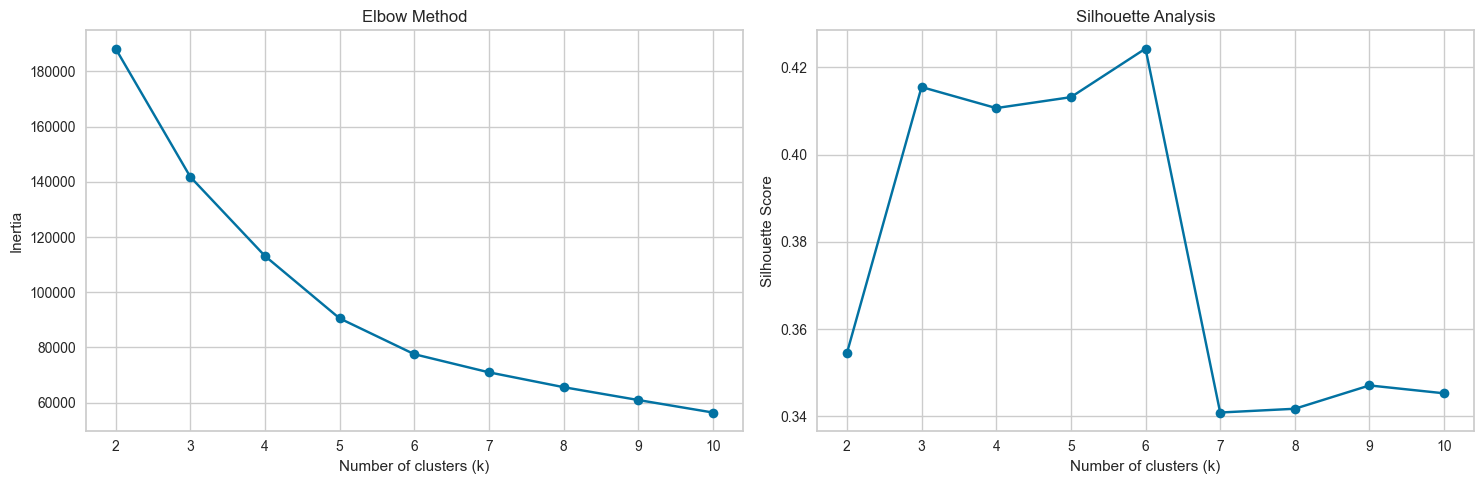

In [32]:
# Plot elbow curve and silhouette scores
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.plot(range(2, max_k + 1), inertias, marker='o')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method')

plt.subplot(1, 2, 2)
plt.plot(range(2, max_k + 1), silhouette_scores, marker='o')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Analysis')

plt.tight_layout()
plt.show()

In [ ]:
# Perform K-means clustering with optimal k (using 3 clusters as per your original code)
n_clusters = 3
kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
df['Cluster'] = kmeans.fit_predict(scaled_features)

# Visualization 1: Price vs Availability scatter plot
plt.figure(figsize=(12, 8))
sns.scatterplot(data=df, x='price', y='availability_365', 
                hue='Cluster', palette='deep', alpha=0.6)
plt.title('Price vs Availability by Cluster', fontsize=14)
plt.xlabel('Price (USD)', fontsize=12)
plt.ylabel('Availability (Days/Year)', fontsize=12)
plt.legend(title="Cluster")
plt.show()

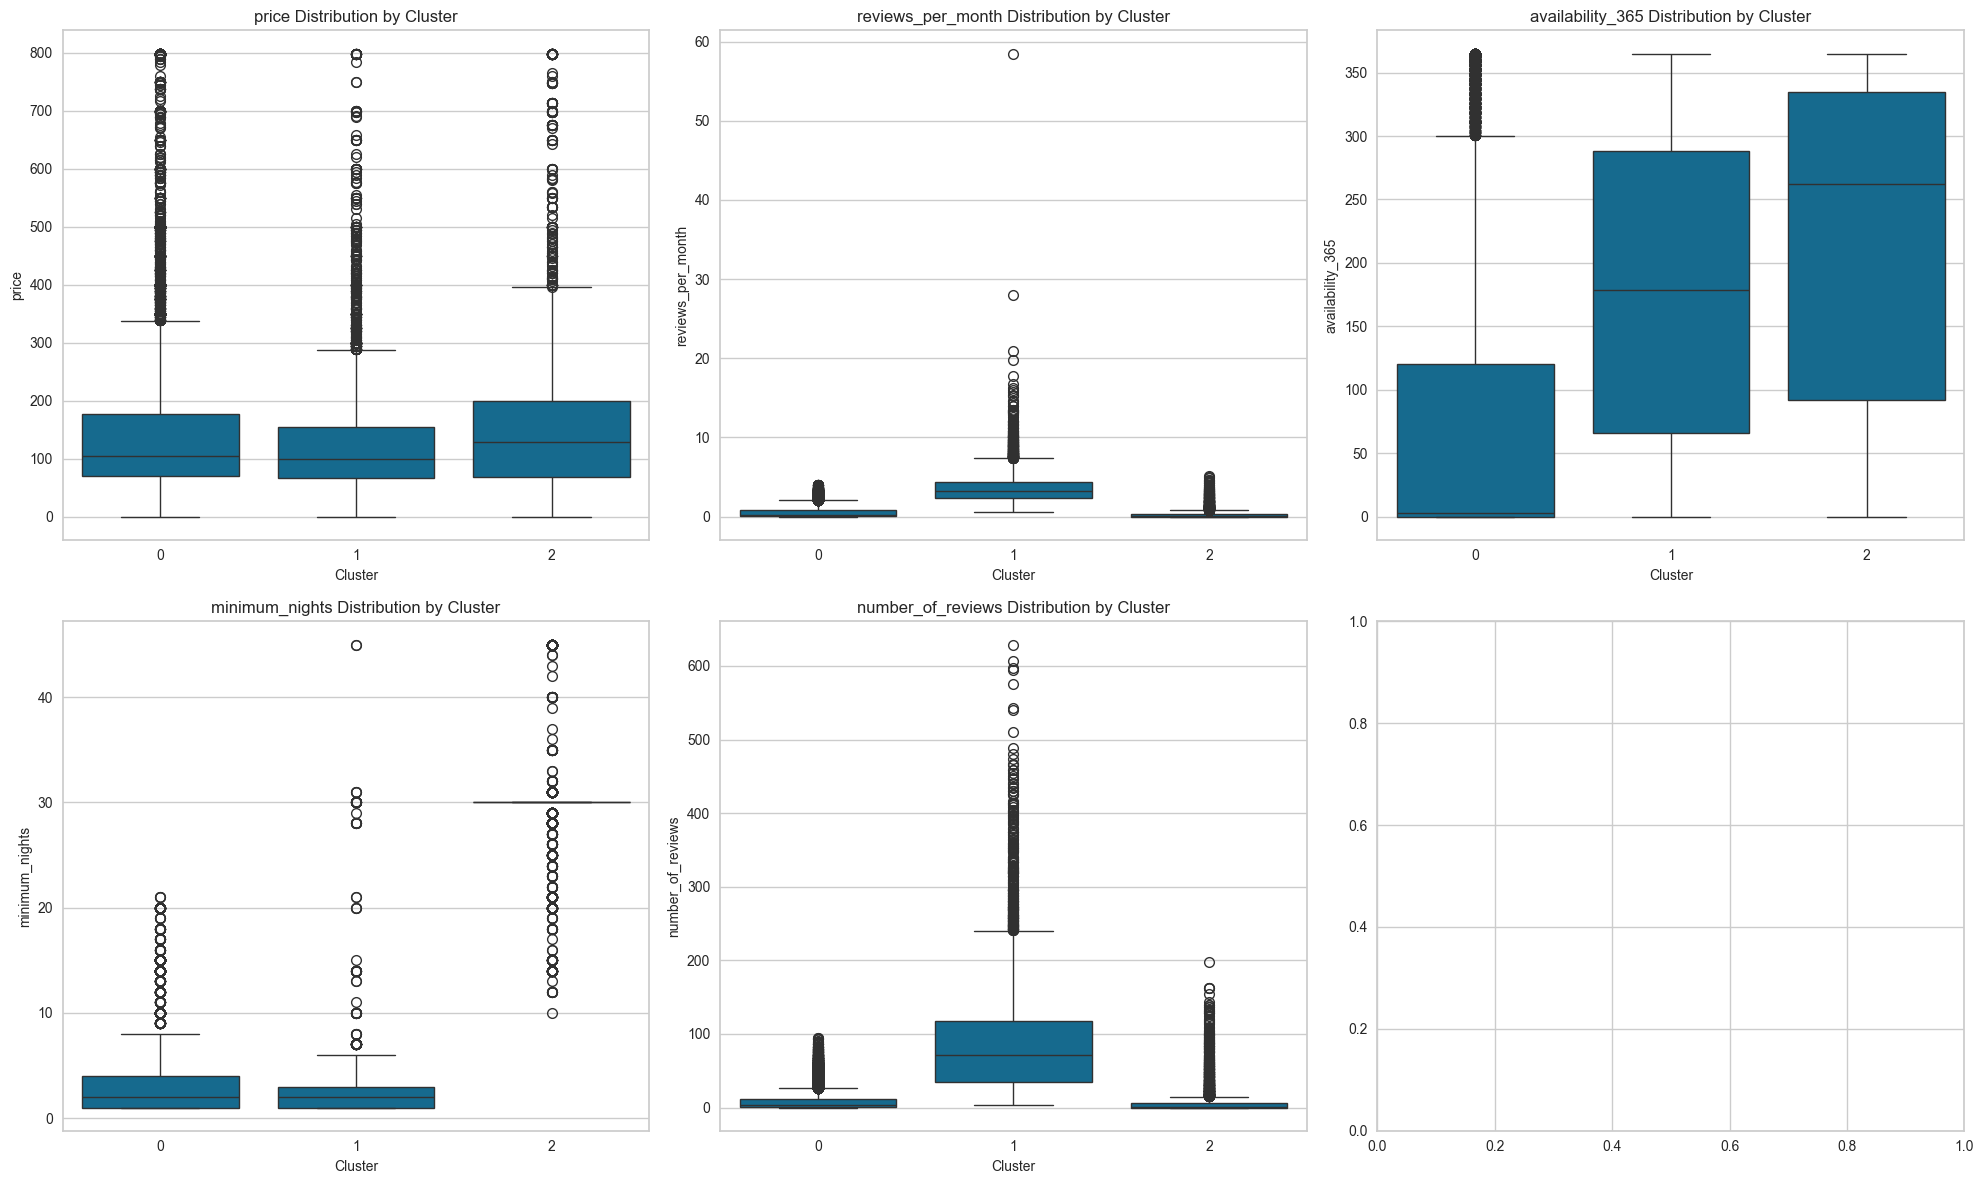

In [33]:
# Visualization 2: Feature distributions by cluster
features = ['price', 'reviews_per_month', 'availability_365', 
            'minimum_nights', 'number_of_reviews']

fig, axes = plt.subplots(2, 3, figsize=(20, 12))
axes = axes.ravel()

for idx, feature in enumerate(features):
    if idx < len(axes):
        sns.boxplot(data=df, x='Cluster', y=feature, ax=axes[idx])
        axes[idx].set_title(f'{feature} Distribution by Cluster', fontsize=12)
        axes[idx].set_xlabel('Cluster', fontsize=10)
        axes[idx].set_ylabel(feature, fontsize=10)

plt.tight_layout()
plt.show()

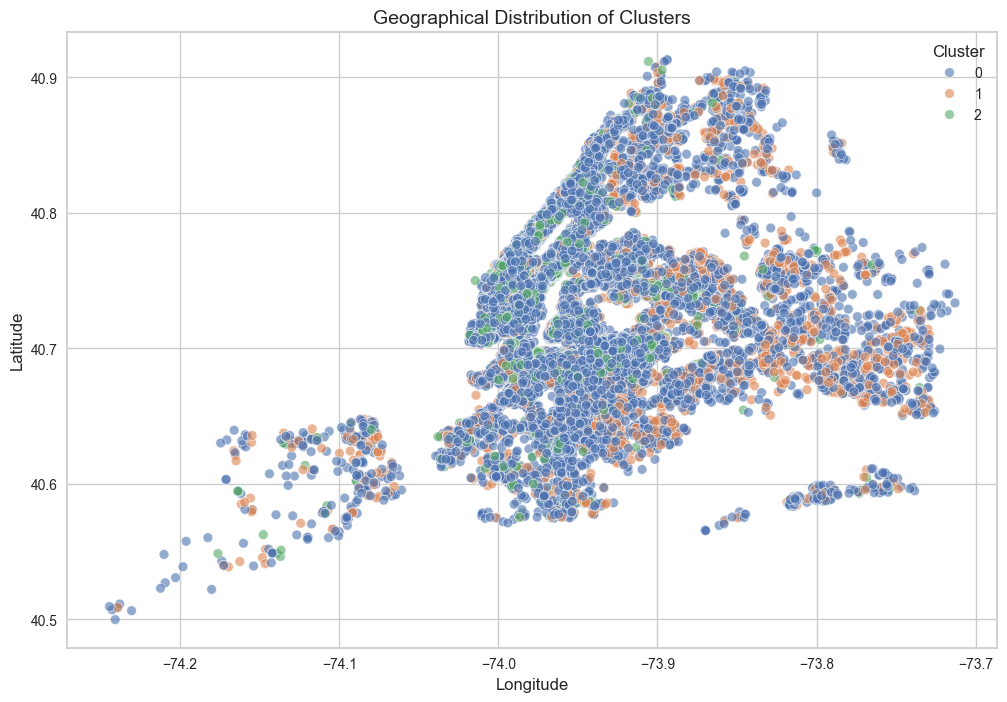

In [34]:
# Visualization 3: Geographical distribution
plt.figure(figsize=(12, 8))
sns.scatterplot(data=df, x='longitude', y='latitude', 
                hue='Cluster', palette='deep', alpha=0.6)
plt.title('Geographical Distribution of Clusters', fontsize=14)
plt.xlabel('Longitude', fontsize=12)
plt.ylabel('Latitude', fontsize=12)
plt.legend(title="Cluster")
plt.show()

In [35]:
# Display cluster statistics
print("\nCluster Statistics:")
cluster_stats = df.groupby('Cluster').agg({
    'price': ['mean', 'median', 'std'],
    'reviews_per_month': ['mean', 'median', 'std'],
    'availability_365': ['mean', 'median', 'std'],
    'minimum_nights': ['mean', 'median', 'std'],
    'number_of_reviews': ['mean', 'median', 'std']
}).round(2)
display(cluster_stats)


Cluster Statistics:


price                reviews_per_month               \
           mean median     std              mean median   std   
Cluster                                                         
0        145.45  105.0  125.40              0.54   0.22  0.71   
1        128.49  100.0   96.14              3.60   3.28  1.91   
2        160.59  129.0  135.40              0.29   0.09  0.54   

        availability_365                minimum_nights               \
                    mean median     std           mean median   std   
Cluster                                                               
0                  77.42    3.0  117.91           3.23    2.0  2.81   
1                 178.90  179.0  119.37           2.19    2.0  2.13   
2                 219.31  262.0  130.65          30.30   30.0  5.70   

        number_of_reviews                
                     mean median    std  
Cluster                                  
0                    8.94    3.0  13.16  
1                   85.69   71.0  69.81  
2                    7.29    1.0  16.86


Room Type Distribution by Cluster (%):


room_type,Entire home/apt,Private room,Shared room
Cluster,,,
0,49.925090,47.657237,2.417673
1,49.810708,48.004327,2.184965
2,68.072505,29.522613,2.404882


<Figure size 1200x600 with 0 Axes>

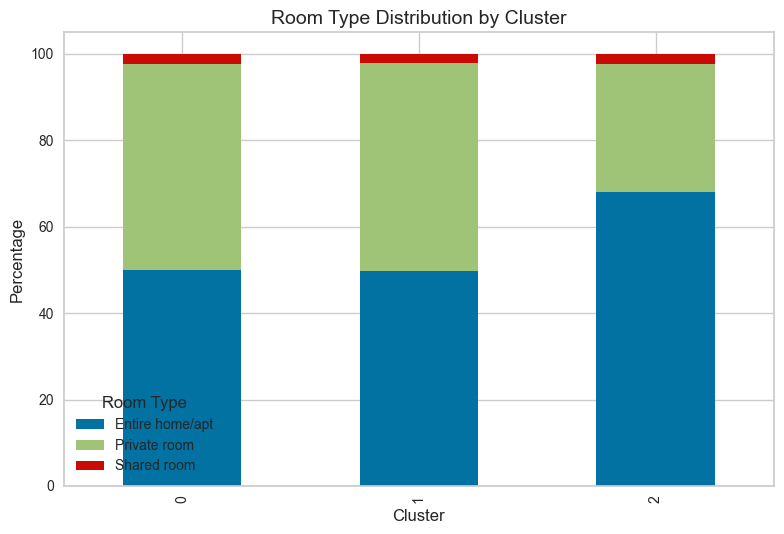

In [36]:
# Display room type distribution
print("\nRoom Type Distribution by Cluster (%):")
room_type_dist = pd.crosstab(df['Cluster'], 
                            df['room_type'], 
                            normalize='index') * 100
display(room_type_dist)

# Additional visualization: Room type distribution by cluster
plt.figure(figsize=(12, 6))
room_type_dist.plot(kind='bar', stacked=True)
plt.title('Room Type Distribution by Cluster', fontsize=14)
plt.xlabel('Cluster', fontsize=12)
plt.ylabel('Percentage', fontsize=12)
plt.legend(title="Room Type")
plt.tight_layout()
plt.show()

##  Key Insights  

- **Most high-priced listings are concentrated in Manhattan**   
- Especially in **Midtown, Tribeca, SoHo, and the Upper East Side**.  
- **Brooklyn has a few high-end listings**, mainly in **Williamsburg & DUMBO**.  
- **Queens, Bronx, and Staten Island have very few luxury listings** *(mostly budget-friendly)*.  

##  Map Insights  
- **Luxury Airbnb stays are primarily located in high-tourism areas (Manhattan)**.  
- **Brooklyn has some upscale areas**, but fewer than Manhattan.  
- **Queens and the Bronx are more budget-oriented Airbnb markets**.  
-  **This suggests that Airbnb luxury rentals are primarily concentrated in key NYC tourism hotspots**.  


#  **Overview**

This report provides an **in-depth analysis of Airbnb listings in New York City**, examining **pricing trends, seasonality, host market structure, rental preferences, and revenue potential**.  
The findings offer valuable insights for **hosts, investors, and policymakers** looking to understand the **Airbnb market in NYC**.  

---

##  1. Pricing Insights  
- **Manhattan is the most expensive borough** → **$182.96 per night**  
- **The Bronx is the cheapest borough** → **$85.72 per night**  
- **Entire homes/apartments cost significantly more** (**$198.33**) compared to **private rooms** (**$86.01**).  
- **Luxury listings ($500+) are concentrated in Manhattan** *(Midtown, Tribeca, SoHo)*.  

 **Recommendation:**  
- **Target budget travelers in Queens & Bronx** by offering more **affordable, well-reviewed private rooms**.  
- **Luxury property investors should focus on Manhattan’s high-end locations**.  

---

##  2. Availability & Demand Trends  
- **Shared rooms have the highest availability** (~161 days per year).  
- **Many listings (35%) have 0 availability**, suggesting **inactive or seasonal properties**.  
- **High-review properties receive 100+ reviews**, while many listings **get little to no engagement**.  

 **Recommendation:**  
- **Optimize pricing strategies for high-availability listings** to attract **long-term guests**.  
- **Inactive hosts should be targeted with promotions or incentives** to increase engagement.  

---

##  3. Host Market Structure  
- **Most hosts own just 1 listing (75%)**, but **6.5% of hosts control 10+ listings**.  
- **A small number of hosts dominate the market**, likely as **commercial operators**.  

 **Recommendation:**  
- **Airbnb should monitor multi-listing hosts** to prevent **market monopolization**.  
- **New hosts should be encouraged with incentives** to balance the market.  

---

##  4. Review & Guest Engagement Insights  
- **Median reviews per listing = 5** *(many listings receive little feedback)*.  
- **Only 6% of listings have 100+ reviews**, meaning a **small % of properties dominate guest interest**.  

 **Recommendation:**  
- **Airbnb should incentivize guests to leave reviews** *(e.g., discounts for review submissions)*.  
- **Hosts with low review counts should consider offering discounted stays** to boost engagement.  

---

##  5. Geospatial Insights  
- **Most listings are concentrated in Manhattan & Brooklyn**.  
- **Luxury listings ($500+) are primarily in Midtown, Tribeca, and SoHo**.  
- **Queens & Bronx are underrepresented in listings** but can **attract budget-conscious travelers**.  

 **Recommendation:**  
- **Airbnb should promote underrepresented boroughs (Queens, Bronx) with marketing campaigns**.  
- **New hosts should be encouraged to list budget stays in these areas**.  

## 6. Pricing & Seasonality Trends:

- **Peak demand months:** **May - August** *(highest guest activity)*.  
- **Slowest months:** **January - February** *(low demand)*.  
- **Winter discounts & summer surge pricing** can **maximize revenue**.  
- **Manhattan is the most expensive borough** *(~$183 per night)*.  
- **Entire homes/apartments charge the highest prices** *(~$198 per night)*.  

 **Recommendations:**  
- **Adjust pricing dynamically** based on **demand fluctuations**.  
- **Offer off-season discounts (Jan-Feb)** to attract bookings.  

---

## 7. Host Market Structure:  

- **Most hosts (86%) own just one property**, while **14% of hosts own multiple listings**.  
- **Multi-property hosts dominate high-revenue segments**.  

 **Recommendations:**  
- **Single-property hosts should focus on guest experience** to compete with **multi-listing hosts**.  
- **Regulators may enforce restrictions on multi-property hosts**, so **compliance is key**.  

---

## 8. Short-Term vs. Long-Term Rentals: 

- **85% of listings are short-term rentals (≤7 nights)**, catering primarily to **tourists**.  
- **Long-term rentals (monthly stays) account for 15% of listings**.  
- **Long-term rentals generate slightly higher revenue** *(~$149 per night)*.  

 **Recommendations:**  
- **Consider long-term rentals during low season** to stabilize income.  
- **Hosts can target digital nomads & remote workers** for extended stays.  

---

## 9. Revenue Potential:

- **Manhattan hosts earn the most** *(~$23,975 per year)*.  
- **Staten Island ranks second in revenue** *(~$20,208 per year)*, an unexpected trend.  
- **Entire homes generate far higher income** *(~$25,338 per year)* than private/shared rooms.  

 **Recommendations:**  
- **Investing in entire home rentals** in **high-demand areas** *(Manhattan, Staten Island)* **maximizes revenue**.  
- **Shared rooms have low revenue potential** and **may not be worth listing**.  

---

#  **Final Recommendations**  

1. **Optimize pricing based on seasonality & borough demand.**  
2. **Short-term rentals dominate, but long-term rentals can be a strategic option.**  
3. **Entire home rentals in high-demand areas yield the highest revenue.**  
4. **Multi-listing hosts dominate the market—single hosts should differentiate via guest experience.**  
